# Capstone - Facial Keypoints Detection (benchmark model)

First of all let's discuss what we are given.<br>
We are given three CSV files.<br>
training.csv :- Its has coordinates of facial keypoints like left eye, rigth eye etc and also the image.<br>
test.csv :- Its has image only and we have to give coordinates of various facial keypoints by looking at third csv file which is <br> 
IdLookupTable.csv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os

In [2]:
os.listdir('.')

['.ipynb_checkpoints',
 'Capstone - Facial Keypoints Detection (benchmark model).ipynb',
 'IdLookupTable.csv',
 'SampleSubmission.csv',
 'test',
 'training']

In [3]:
Train_Dir = './training/training.csv'
Test_Dir = './test/test.csv'
lookid_dir = './IdLookupTable.csv'
train_data_frame = pd.read_csv(Train_Dir)  
test_data_frame = pd.read_csv(Test_Dir)
lookid_data_frame = pd.read_csv(lookid_dir)

Lets explore our dataset

In [4]:
train_data_frame.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


Lets check for missing values

In [5]:
# dF.isnull() Returns the same DF but with True whenever NAN(or empty string or numpy.inf) exist, and Flase elsewhere

# dF.any() Return whether any element is True, potentially over an axis. (default axis is the row, i.e the index axis)
       #### what i see is that it did that for each column then transposed the dF into a series !!
       #### here it returns a series (the single column dataFrame in Pandas)

# Series.value_counts Return a Series containing counts of unique values.

train_data_frame.isnull().any(axis=0).value_counts()

True     28
False     3
dtype: int64

In [6]:
# see number of rows that have NAN values
train_data_frame.isnull().any(axis=1).value_counts()

True     4909
False    2140
dtype: int64

- So there are missing values in 28 columns. We can do one of two things here:
    - one : remove the rows having missing values 
    - two : ill missing values with some data. 

using option one will reduce our dataset drastically (more than half of the rows have NAN values!!), so i uesd option two
I filled the missing values with the previous values in that row.

In [7]:
train_data_frame.fillna(method = 'ffill',inplace = True)

Lets check for missing values now

In [8]:
train_data_frame.isnull().any().value_counts()

False    31
dtype: int64

- now, there are no missing values. 
- we can now separate features and target(labels). 
    - The image is our feature and the other values are labels that we have to predict later. 
    
- since image column values are in string format and there are also some missing values (pixels !) so we have to split the pixels' string by space and append it to an list (to be able to display it) and also handling missing values(missing pixels)
    - we will put "0" in place of the missing pixel

In [9]:
images_lists = list()
num_of_images = 7049

for i in range(num_of_images): # for each string that corresponds to an iamge
    img_temp_list = train_data_frame['Image'][i].split(' ') # convert the long string into small strings (individual pixels)
    img_temp_list = ['0' if x == '' else x for x in img_temp_list] # handle pixel if is missing -> make it zero
    images_lists.append(img_temp_list)

- notes
    - `train_data_frame['Image'][0]` is a string, corresponds to the first image
    - `string.split(' ')` returns a list of strings, the strings are made from spliting the original long `string` when incountering a ' '

Lets reshape the image (whiile in the same time make it an array) and convert the image list from being as pixels strings into pixels as float value.

In [10]:
images_array = np.array(images_lists,dtype = 'float') 


In [11]:
X_train = images_array.reshape(-1,96,96)  # of shape 7094*96*96*1

- note:
    - `image_array` is a numpy array of the size of `7049 x 9216` = `n_images x n_pixels_in_each_image`
        - i.e each row corresponds to an image
    - `X_train` is of shape `7049 x 96 x 96`
        - note that putting the first dimension as -1 in the reshape function means that the first dimension is inferred from the calling ndarray, `images_array`. 

Lets see what is the first image.

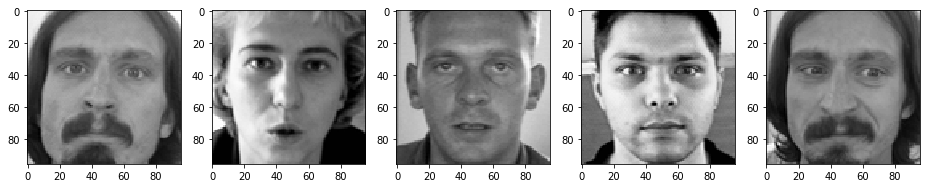

In [12]:
# method 1 in plotting : 
# showing single image
##plt.imshow(X_train[0],cmap='gray')
##plt.show()

# method 2 in plotting : 
# showing several images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,16))

for i in range (5):
    axes[i].imshow(X_train[i],cmap='gray')
   

### here i want to plot the images with its markers

#### separating labels.

In [13]:
training = train_data_frame.drop('Image',axis = 1)

y_train = []
for i in range(0,7049):
    y = training.iloc[i,:]

    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

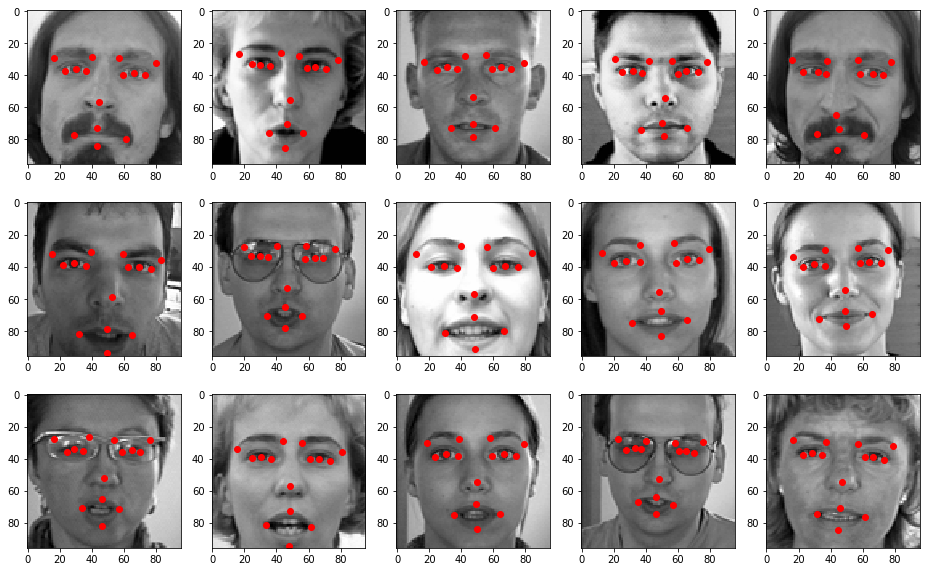

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16,10))

for i in range(3):
    for j in range(5):
        axes[i][j].imshow(X_train[5*i+j],cmap='gray')
        axes[i][j].plot(y_train[5*i+j][0::2], y_train[5*i+j][1::2], 'ro')

## Training
As our data is ready for training , lets define our model. I am using keras and simple dense layers. 
For both loss function and evaluation of the result I am using 'MSE' ( mean squared error ).  (my note: I can use a loss function but evaluate the result against another function. (i.e MSE for one, and MAE for the other))

#### Split train and test data

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Train a Multilayer Perceptron nn for benchmark
- In order to train our neural network to classify images we first have to unroll the height x width pixel format into one big vector - the *input vector*. So its length must be $96 \cdot 96 =  9216$.

- Also Normalizing the input data helps to speed up the training. Also, it reduces the chance of getting stuck in local optima, since we're using stochastic gradient descent to find the optimal weights for the network.<br><br>

- So let's reshape our inputs to a single vector vector and normalize the pixel values to lie between 0 and 1.

In [16]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(5639, 9216)
X_test = X_test.reshape(1410, 9216)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (5639, 96, 96)
y_train shape (5639, 30)
X_test shape (1410, 96, 96)
y_test shape (1410, 30)
Train matrix shape (5639, 9216)
Test matrix shape (1410, 9216)


#### Defining the model

In [17]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

Using TensorFlow backend.


In [18]:
model = Sequential()

model.add(Dense(512, input_shape=(9216,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4719104   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)  

In [19]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mse'])

Now our model is defined and we will train it by calling fit method. I ran it for 500 iteration (how?!) keeping batch size and validtion set size as 20% ( 20% of the training data will be kept for validating the model ).

In [20]:
history = model.fit(X_train,y_train,epochs = 50,batch_size = 256, validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 4511 samples, validate on 1128 samples
Epoch 1/50
4511/4511 [==============================] - 6s 1ms/step - loss: 696.8001 - mean_squared_error: 696.8001 - val_loss: 164.9843 - val_mean_squared_error: 164.9843
Epoch 2/50
4511/4511 [==============================] - 3s 582us/step - loss: 252.5164 - mean_squared_error: 252.5164 - val_loss: 141.0187 - val_mean_squared_error: 141.0187
Epoch 3/50
4511/4511 [==============================] - 3s 582us/step - loss: 202.6929 - mean_squared_error: 202.6929 - val_loss: 135.6401 - val_mean_squared_error: 135.6401
Epoch 4/50
4511/4511 [==============================] - 3s 571us/step - loss: 186.2167 - mean_squared_error: 186.2167 - val_loss: 127.7079 - val_mean_squared_error: 127.7079
Epoch 5/50
4511/4511 [==============================] - 3s 591us/step - loss: 171.7603 - mean_squared_error: 171.7603 - val_loss: 131.7653 - val_mean_squared_error: 131.7653
Epoch 6/50
4511/4511 [==============

Epoch 47/50
4511/4511 [==============================] - 3s 568us/step - loss: 40.7961 - mean_squared_error: 40.7961 - val_loss: 24.7748 - val_mean_squared_error: 24.7748
Epoch 48/50
4511/4511 [==============================] - 3s 571us/step - loss: 34.2095 - mean_squared_error: 34.2095 - val_loss: 24.7943 - val_mean_squared_error: 24.7943
Epoch 49/50
4511/4511 [==============================] - 3s 571us/step - loss: 30.0413 - mean_squared_error: 30.0413 - val_loss: 36.5907 - val_mean_squared_error: 36.5907
Epoch 50/50
4511/4511 [==============================] - 3s 562us/step - loss: 27.8515 - mean_squared_error: 27.8515 - val_loss: 16.3603 - val_mean_squared_error: 16.3603


In [21]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


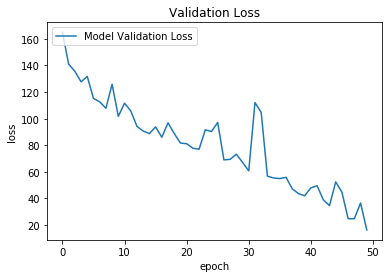

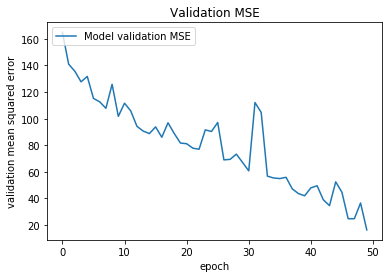

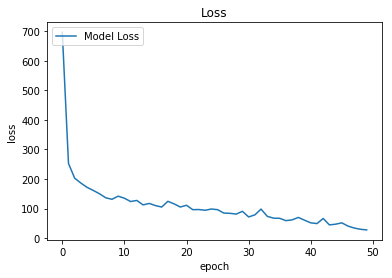

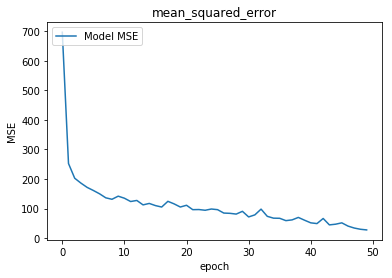

In [22]:
# Plot validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Model Validation Loss',], loc='upper left')
plt.show()

# Plot validation mean squared error
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation MSE')
plt.ylabel('validation mean squared error')
plt.xlabel('epoch')
plt.legend(['Model validation MSE'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Model Loss'], loc='upper left')
plt.show()

# Plot 'mean_absolute_error
plt.plot(history.history['mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Model MSE'], loc='upper left')
plt.show()

#### validation result

In [23]:
print("MSE before training = {0:.2f}" .format(history.history['mean_squared_error'][0]))
print("MSE after training = {0:.2f}" .format(history.history['mean_squared_error'][len(history.history['mean_squared_error']) -1]))

MSE before training = 696.80
MSE after training = 27.85


#### Testing

In [24]:
pred = model.predict(X_test)

#### testing results

In [25]:
from sklearn.metrics import mean_squared_error
mse_test = mean_squared_error(y_test,pred)

print("MSE in testing matrix = {0:.2f}" .format(mse_test))

MSE in testing matrix = 18.31


#### visualize the pictures after using the model prediction

In [26]:
# should i mul x_train by 255 ? Apparantly no

# return size of the test matrices to the original size
X_test = X_test.reshape(1410, 96, 96)

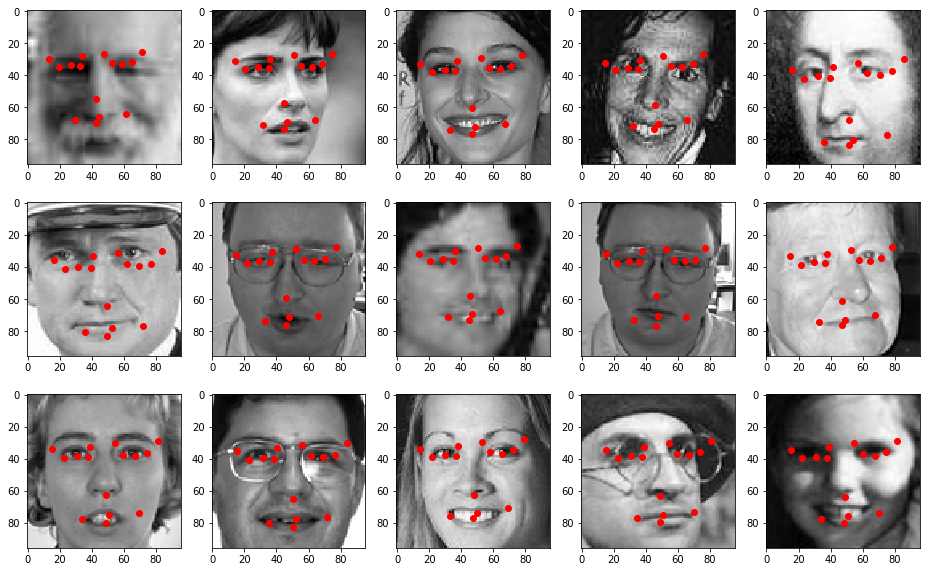

In [27]:
# plot
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16,10))

for i in range(3):
    for j in range(5):
        axes[i][j].imshow(X_test[5*i+j],cmap='gray')
        axes[i][j].plot(pred[5*i+j][0::2], pred[5*i+j][1::2], 'ro')